In [1]:
import random

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import numpy as np
import selectivesearch

%matplotlib inline

# Read Data

In [24]:
header = 'VOCdevkit/VOC2012/'
with open(header + 'ImageSets/Segmentation/train.txt', 'r') as f:
    trainf = [line.strip() for line in f.readlines()]
    
with open(header + 'ImageSets/Segmentation/val.txt', 'r') as f:
    valf = [line.strip() for line in f.readlines()]

In [25]:
def parse_xml(image_name):
    annotations = open(header + 'Annotations/' + image_name + '.xml').read()
    annotations = BeautifulSoup(annotations, 'html5lib')

    size = annotations.annotation.size
    w, h, d = int(size.width.text), int(size.height.text), int(size.depth.text)

    object_lst = []
    objects = annotations.findAll('object')
    for i, o in enumerate(objects):
        name = o.find('name').text
        xmin, xmax = int(o.bndbox.xmin.text), int(o.bndbox.xmax.text)
        ymin, ymax = int(o.bndbox.ymin.text), int(o.bndbox.ymax.text)
        
        object_lst.append({
            'name': name,
            'xmin': xmin,
            'xmax': xmax,
            'ymin': ymin,
            'ymax': ymax
        })
    
    return {
        'size': (w, h, d),
        'objects': object_lst,
    }

In [26]:
def load_image(image_name):
    image = Image.open(header + 'JPEGImages/' + image_name + '.jpg')
    annotations = parse_xml(image_name)

    seg_class = Image.open(header + 'SegmentationClass/' + image_name + '.png')
    seg_object = Image.open(header + 'SegmentationObject/' + image_name + '.png')
    
    output = {
        'image': image,
        'seg_class': seg_class,
        'seg_object': seg_object
    }
    output.update(annotations)
    
    return output

In [64]:
def is_positive(bnd_boxes, region):
        return max(IoU(bnd_box, region) for bnd_box in bnd_boxes) >= 0.5
    
def IoU(bnd_box, region):
    xmin1, xmax1, ymin1, ymax1 = bnd_box
    xmin2, xmax2, ymin2, ymax2 = region

    bnd_box_area = (xmax1 - xmin1) * (ymax1 - ymin1)
    region_area = (xmax2 - xmin2) * (ymax2 - ymin2)

    x_overlap = max(0, min(xmax1, xmax2) - max(xmin1, xmin2))
    y_overlap = max(0, min(ymax1, ymax2) - max(ymin1, ymin2))

    intersection = x_overlap * y_overlap
    union = bnd_box_area + region_area - intersection
    
    return intersection / union

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7FD2BE2D2BE0>
Object 0: chair, 274, 386, 84, 269
Object 1: chair, 398, 500, 184, 322
Object 2: tvmonitor, 405, 450, 86, 134
Object 3: bottle, 25, 70, 223, 334


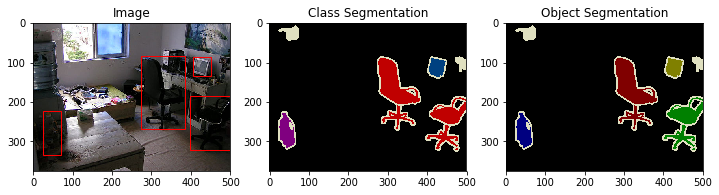

In [101]:
image_name = random.choice(trainf)
image_data = load_image(image_name)
print(image_data['image'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 16))
ax1.set_title('Image')
ax1.imshow(image_data['image'])

for i, o in enumerate(image_data['objects']):
    name = o['name']
    xmin, xmax = o['xmin'], o['xmax']
    ymin, ymax = o['ymin'], o['ymax']
    
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    
    print('Object %s: %s, %s, %s, %s, %s' % (i, name, xmin, xmax, ymin, ymax))

ax2.set_title('Class Segmentation')
ax2.imshow(image_data['seg_class'])
ax3.set_title('Object Segmentation')
ax3.imshow(image_data['seg_object'])

# Selective Search

[(274, 386, 84, 269), (398, 500, 184, 322), (405, 450, 86, 134), (25, 70, 223, 334)]


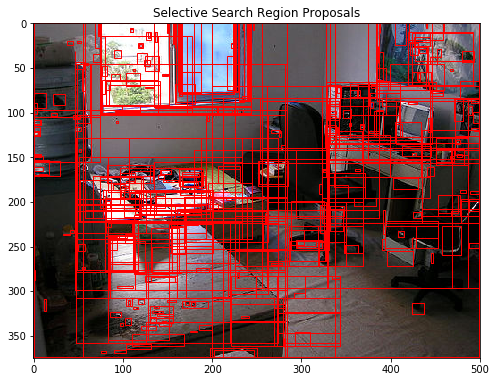

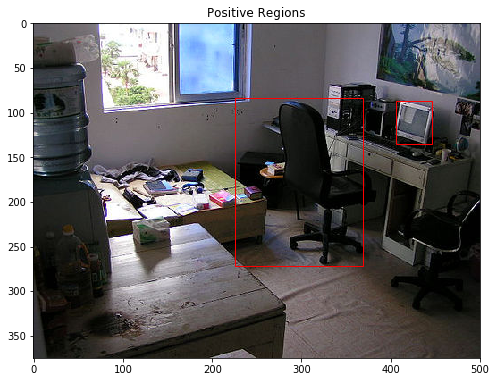

In [102]:
_, regions1 = selectivesearch.selective_search(np.array(image_data['image']), scale=500, sigma=0.9, min_size=10)
_, regions2 = selectivesearch.selective_search(np.array(image_data['image']), scale=1000, sigma=0.9, min_size=10)
regions = regions1 + regions2

fig, ax = plt.subplots(figsize=(8, 12))
ax.set_title('Selective Search Region Proposals')
ax.imshow(image_data['image'])

for r in regions:
    rect = patches.Rectangle((r['rect'][0], r['rect'][1]), r['rect'][2], r['rect'][3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
fig, ax = plt.subplots(figsize=(8, 12))
ax.set_title('Positive Regions')
ax.imshow(image_data['image'])

bnd_boxes = [(o['xmin'], o['xmax'], o['ymin'], o['ymax']) for o in image_data['objects']]
print(bnd_boxes)
for r in regions:
    region = (r['rect'][0] , r['rect'][0] + r['rect'][2], r['rect'][1], r['rect'][1] + r['rect'][3])
    if is_positive(bnd_boxes, region):
        rect = patches.Rectangle((r['rect'][0], r['rect'][1]), r['rect'][2], r['rect'][3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

# Fine-tuning CNN

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [ ]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, imageset):
        self.idx2label = {}
        self.label2idx = {}
        self.counter = 0
        
        self.negative = []
        self.positive = []
        self.npositive = 0
        
        self.imageset = imageset
        
        self.get_labels()
        self.generate_dataset()
        
    def labels(self):
        return self.lable2idx.keys()
    
    def get_labels(self):
        for img in imageset:
            out = parse_xml(img)
            labels = set([o['name'] for o in out['objects']])
            for label in labels:
                if label not in self.label2idx:
                    self.add_label(label)
        self.add_label('background')
                
    def add_label(self, label):
        self.label2idx[label] = self.counter
        self.idx2label[self.counter] = label
        self.counter += 1
    
    def generate_dataset(self):
        for i, image in enumerate(imageset):
            image_data = load_image(image)
            bnd_boxes = [(o['xmin'], o['xmax'], o['ymin'], o['ymax']) for o in image_data['objects']]
            _, regions = selectivesearch.selective_search(np.array(image_data['image']),
                                                             scale=500, sigma=0.9, min_size=10)
            for r in regions:
                region = (r['rect'][0] , r['rect'][0] + r['rect'][2], r['rect'][1], r['rect'][1] + r['rect'][3])
                if self.is_positive(bnd_boxes, region):
                    datum = (imageset, self.label2idx[r['name']]) + region
                    self.positive.append(datum)
                else:
                    datum = (imageset, self.label2idx['background']) + region
                    self.negative.append(datum)
            print(i)

        self.npositive = len(self.positive)
    
    def is_positive(self, bnd_boxes, region):
        return max(self.IoU(bnd_box, region) for bnd_box in bnd_boxes) >= 0.5
    
    def IoU(self, bnd_box, region):
        xmin1, xmax1, ymin1, ymax1 = bnd_box
        xmin2, xmax2, ymin2, ymax2 = region
        
        bnd_box_area = (xmax1 - xmin1) * (ymax1 - ymin1)
        region_area = (xmax2 - xmin2) * (ymax2 - ymin2)
        
        x_overlap = max(0, min(xmax1, xmax2) - max(xmin1, xmin2))
        y_overlap = max(0, min(ymax1, ymax2) - max(ymin1, ymin2))
        
        intersection = x_overlap * y_overlap
        union = bnd_box_area + region_area - intersection
        
        return intersection / union
    
    def __len__(self):
        return len(self.positive) + len(self.negative)
    
    def __getitem__(self, index):
        if index < self.npositive:
            return self.positive[index]
        else:
            return self.negative[index - self.npositive]

In [ ]:
model = models.resnet18()

In [ ]:
model.fc = nn.Linear